# Humpback Whale Identification - CNN with Keras
This kernel is based on [Anezka Kolaceke](https://www.kaggle.com/anezka)'s awesome work: [CNN with Keras for Humpback Whale ID](https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id)

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# from keras.preprocessing import image
# from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model

import keras.backend as K
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3
NUM_CLASSES = 3500
BATCH_SIZE = 8
EPOCHS = 20
MAX_TRAIN_STEPS = 100

In [3]:
train_df = pd.read_csv("train.csv")
train_df.head()
NUM_CLASSES = train_df['Id'].nunique()
print('Unique classes-',NUM_CLASSES)
CLASS_DICT = {}
CLASS_DICT_REV = {}
ctr=0
for whale_class in train_df['Id'].unique():
    CLASS_DICT[whale_class] = ctr
    CLASS_DICT_REV[str(ctr)] = whale_class
    ctr+=1
print("NUM_CLASSES", NUM_CLASSES)

Unique classes- 5005
NUM_CLASSES 5005


In [4]:
from sklearn.model_selection import train_test_split

d_train_list = []
d_test_list = []

train_df.head()
train_df = train_df[train_df.Id != 'new_whale']
# print(train_df.groupby(['Id'])['Image'].apply(list).to_dict())
splitting_dict = train_df.groupby(['Id'])['Image'].apply(list).to_dict()
for whale_id in splitting_dict.keys():
#     print('whale_id',whale_id,'Images',splitting_dict[whale_id])
    if len(splitting_dict[whale_id]) > 1:
        train_list, test_list = train_test_split(splitting_dict[whale_id], test_size=0.4)
    else:
        train_list = splitting_dict[whale_id]
        test_list = splitting_dict[whale_id]
#     print('Train_list',len(train_list),'test',len(test_list))
    for imgs in train_list:
        d_train_list.append([whale_id, imgs])
    for imgs in test_list:
        d_test_list.append([whale_id, imgs])
        
# print(d_train_list)
d_train = pd.DataFrame(d_train_list,columns=['Id','Image'])
d_test = pd.DataFrame(d_test_list,columns=['Id','Image'])

In [5]:
# print(d_train.groupby(['Id'])['Image'].apply(list).to_dict())

## Make Generator

In [6]:
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def get_image(index, data, test):
    img = cv2.imread('train/'+data['Image'].values[index].strip())
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = clahe.apply(img)
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
#     img = np.expand_dims(img, axis=-1)
    digit_class = CLASS_DICT[data['Id'].values[index]]
    return img/255.0, digit_class

def make_image_gen(data, batch_size = BATCH_SIZE, test=False):
    while True:
        # Randomize the indices to make an array
        indices_arr = np.random.permutation(data.count()[0])
        for batch in range(0, len(indices_arr), batch_size):
            # slice out the current batch according to batch-size
            current_batch = indices_arr[batch:(batch + batch_size)]

            # initializing the arrays, x_train and y_train
            image_arr = np.empty([0, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], dtype=np.float32)

            y_train = np.empty([0], dtype=np.int32)

            for i in current_batch:
                # get image and its corresponding class(0,1,2,3,....,9)
                image, image_class = get_image(i, data, test)
                image = np.expand_dims(image,axis=0)
                #print(image.shape)

                # Appending them to existing batch
                image_arr = np.append(image_arr, image, axis=0)
                y_train = np.append(y_train, [image_class])
                
            y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

            yield (image_arr, y_train)

## Make train generator

In [7]:
# Read Dataset
# d_train = pd.read_csv(os.path.join('train.csv'))
train_gen = make_image_gen(d_train)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (8, 256, 256, 3) 0.0 1.0
y (8, 5005) 0.0 1.0


## Make validation generator

In [8]:
# Read Dataset
# d_test = pd.read_csv(os.path.join('test.csv'))
test_gen = make_image_gen(d_test, BATCH_SIZE, True)
test_x, test_y = next(test_gen)
print('x', test_x.shape, test_x.min(), test_x.max())
print('y', test_y.shape, test_y.min(), test_y.max())

x (8, 256, 256, 3) 0.0 1.0
y (8, 5005) 0.0 1.0


## Augment Data

In [9]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  brightness_range = [0.8,1.5],
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,  
                  horizontal_flip = True, 
                  vertical_flip = False,
                  fill_mode = 'nearest',
                  data_format = 'channels_last')

def create_aug_gen(in_gen, seed = None):
    image_gen = ImageDataGenerator(**dg_args)
    for in_x, in_y in in_gen:
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0],
                             shuffle=False)

        yield next(g_x)/255.0, in_y

## Test Augmentations

x (8, 256, 256, 3) float32 0.0 1.0
y (8, 5005) float64 0.0 1.0


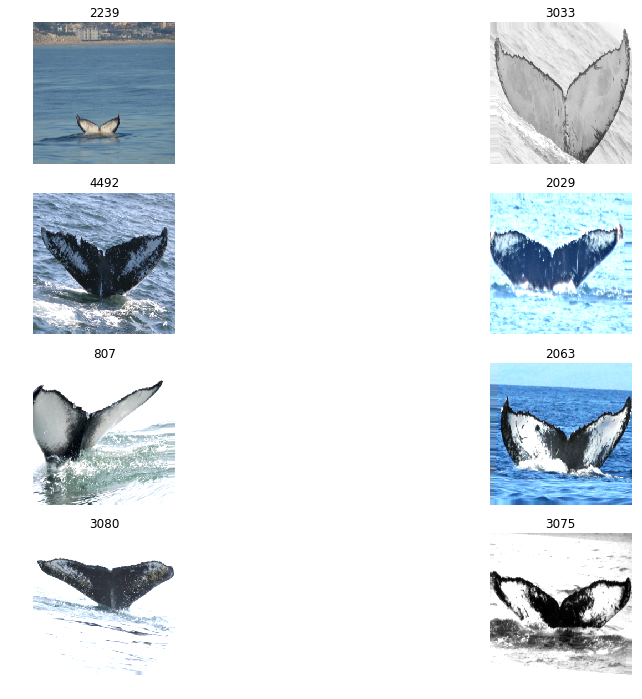

1212

In [10]:
import gc
import matplotlib.pyplot as plt
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 20 samples to examine in detail
t_x = t_x[:20]
t_y = t_y[:20]
fig = plt.figure(figsize=(15,12))
for i in range(4):
  for j in range(2):
    plt.subplot(4,2,i*2 + j +1)
    plt.title(np.argmax(t_y[i*2 + j]))
    plt.imshow(np.reshape(t_x[i*2 + j],(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS))[..., ::-1])
    plt.axis('off')
plt.show()
gc.collect()

In [ ]:
'''
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("./"+dataset+"/"+fig, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train
'''

In [ ]:
'''
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder
'''

In [ ]:
# X = prepareImages(train_df, train_df.shape[0], "train")
# X /= 255

In [ ]:
# y, label_encoder = prepare_labels(train_df['Id'])

In [ ]:
# y.shape

## SE Inception model

In [ ]:
from __future__ import print_function
from __future__ import absolute_import
import warnings

from keras.applications import inception_v3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras import backend as K
from keras import layers
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
import numpy as np
import os


def SE_block(input_layer, ratio=16, is_channel_first=False):
    ''' Create a squeeze-excite block
    Args:
        input_layer: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input_layer
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = init._keras_shape[channel_axis]
    layer_in_shape = (1, 1, filters)

    layer = GlobalAveragePooling2D()(init)
    layer = Reshape(layer_in_shape)(layer)
    layer = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(layer)
    layer = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(layer)

    if K.image_data_format() == 'channels_first':
        layer = Permute((3, 1, 2))(layer)

    out = multiply([init, layer])
    return out

# The InceptionV3 model code is taken from keras_applications/inception_v3.py
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py

def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x

def SE_Inception(include_top=True,
                  weights=None,
                  input_tensor=None,
                  input_shape=None,
                  pooling=None,
                  classes=1000):
    """Instantiates the Inception v3 architecture with Squeeze-Excite blocks.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 139.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=75,
        data_format=K.image_data_format(),
        require_flatten=False,
        weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # squeeze and excite block ----------------------------------------------
    x = SE_block(x)
    #------------------------------------------------------------------------

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = layers.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))

        # squeeze and excite block ----------------------------------------------
        x = SE_block(x)
        #------------------------------------------------------------------------

    if include_top:
        # Classification block
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='inception_v3')
    model.summary()
    return model
    
def preprocess_input(img):
    img /= 255.
    img -= 0.5
    img *= 2.
    return img


In [ ]:
model = SE_Inception(include_top=True, weights=None, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS),
                     classes=NUM_CLASSES)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

In [ ]:
weight_path = "{}_weights.best.hdf5".format('SE_Inception_model')
earlyStopper = EarlyStopping(monitor="val_loss", mode="min", patience=6)
checkPointer = ModelCheckpoint(weight_path, monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min', save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

In [ ]:
# history = model.fit(X, y, epochs=100, batch_size=64, verbose=1,
#                     callbacks=[earlyStopper, reduceLROnPlat, checkPointer])
print('Training started....')

###################  FOR CPU ##################################

train_steps = min(len(d_train)//BATCH_SIZE, MAX_TRAIN_STEPS)
val_steps = min(len(d_test)//BATCH_SIZE, MAX_TRAIN_STEPS//2)

# for GPU remove min()
################################################################

callbacks_list = [earlyStopper, checkPointer, reduceLROnPlat]

history = model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=val_steps,
    verbose=1,
    callbacks=callbacks_list,
    workers=1
)
gc.collect()

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
test = os.listdir("test/")
print(len(test))

In [ ]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [ ]:
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

In [ ]:
predictions = model.predict(np.array(X), verbose=1)

In [ ]:
for i, pred in enumerate(predictions):
#     test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))
      test_df.loc[i,'Id'] = ' '.join([CLASS_DICT_REV[res] for res in pred.argsort()[-5:][::-1]])

In [ ]:
test_df.head(10)
test_df.to_csv('submission.csv', index=False)